# Sequential DQN

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
import numpy as np
state = env.reset()
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action) # take a random action
    print('state, action, next_state, reward, done, info:', state, action, next_state, reward, done, info)
    state = next_state
    if done:
        state = env.reset()

state, action, next_state, reward, done, info: [-0.04276341  0.00320717  0.02395888  0.02209942] 0 [-0.04269927 -0.19225004  0.02440087  0.32224432] 1.0 False {}
state, action, next_state, reward, done, info: [-0.04269927 -0.19225004  0.02440087  0.32224432] 1 [-0.04654427  0.0025161   0.03084575  0.03735523] 1.0 False {}
state, action, next_state, reward, done, info: [-0.04654427  0.0025161   0.03084575  0.03735523] 1 [-0.04649395  0.19718245  0.03159286 -0.24543818] 1.0 False {}
state, action, next_state, reward, done, info: [-0.04649395  0.19718245  0.03159286 -0.24543818] 0 [-0.0425503   0.00162385  0.0266841   0.0570401 ] 1.0 False {}
state, action, next_state, reward, done, info: [-0.0425503   0.00162385  0.0266841   0.0570401 ] 1 [-0.04251782  0.19635323  0.0278249  -0.2271058 ] 1.0 False {}
state, action, next_state, reward, done, info: [-0.04251782  0.19635323  0.0278249  -0.2271058 ] 1 [-0.03859075  0.39106671  0.02328278 -0.51088349] 1.0 False {}
state, action, next_state, r

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
def model_input(state_size, lstm_size, batch_size=1):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    # RNN
    gru = tf.nn.rnn_cell.GRUCell(lstm_size)
    cell = tf.nn.rnn_cell.MultiRNNCell([gru], state_is_tuple=False)
    initial_state = cell.zero_state(batch_size, tf.float32)
    return states, actions, targetQs, cell, initial_state

In [6]:
# RNN generator or sequence generator
def generator(states, num_classes, initial_state, cell, lstm_size, reuse=False): 
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        inputs = tf.layers.dense(inputs=states, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        # dynamic means adapt to the batch_size
        inputs_rnn = tf.reshape(inputs, [1, -1, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=num_classes)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [7]:
def model_loss(action_size, hidden_size, states, cell, initial_state, actions, targetQs):
    actions_logits, final_state = generator(states=states, cell=cell, initial_state=initial_state, 
                                            lstm_size=hidden_size, num_classes=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_logits, final_state, loss

In [8]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # # Optimize
    # with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
    # #opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    #grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(loss, g_vars), clip_norm=5) # usually around 1-5
    grads = tf.gradients(loss, g_vars)
    opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(grads, g_vars))

    return opt

In [9]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, cell, self.initial_state = model_input(
            state_size=state_size, lstm_size=hidden_size)
        
        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.final_state, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, 
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, cell=cell, initial_state=self.initial_state)

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [10]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
        self.states = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx], [self.states[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [11]:
# print('state:', np.array(states).shape[1], 
#       'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

In [27]:
# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 100            # memory capacity - 1000 DQN
batch_size = 100             # experience mini-batch size - 20 DQN
gamma = 0.99                 # future reward discount

In [28]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 2)


## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [29]:
state = env.reset()
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.states.append(np.zeros([1, hidden_size]))
    state = next_state
    if done is True:
        # Reseting the env/first state
        state = env.reset()

In [30]:
# # Training
# batch = memory.buffer
# states = np.array([each[0] for each in batch])
# actions = np.array([each[1] for each in batch])
# next_states = np.array([each[2] for each in batch])
# rewards = np.array([each[3] for each in batch])
# dones = np.array([each[4] for each in batch])

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [31]:
# initial_states = np.array(memory.states)
# initial_states.shape

In [32]:
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()
        initial_state = sess.run(model.initial_state)

        # Training steps/batches
        while True:
            action_logits, final_state = sess.run([model.actions_logits, model.final_state],
                                                  feed_dict = {model.states: state.reshape([1, -1]), 
                                                               model.initial_state: initial_state})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.states.append(initial_state)
            total_reward += reward
            state = next_state
            initial_state = final_state

            # Training
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            initial_states = np.array(memory.states)
            next_actions_logits = sess.run(model.actions_logits, 
                                           feed_dict = {model.states: next_states,
                                                        model.initial_state: initial_states[1]})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                     model.actions: actions,
                                                                     model.targetQs: targetQs,
                                                                     model.initial_state: initial_states[0]})
            # End of training
            loss_batch.append(loss)
            if done is True:
                break
                
        # Outputing: priting out/Potting
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'loss:{:.4f}'.format(np.mean(loss_batch)))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:9.0000 R:9.0000 loss:1.0237
Episode:1 meanR:9.0000 R:9.0000 loss:0.9854
Episode:2 meanR:9.0000 R:9.0000 loss:0.9581
Episode:3 meanR:9.0000 R:9.0000 loss:0.9447
Episode:4 meanR:9.0000 R:9.0000 loss:0.9237
Episode:5 meanR:8.8333 R:8.0000 loss:0.9223
Episode:6 meanR:8.8571 R:9.0000 loss:0.9897
Episode:7 meanR:9.0000 R:10.0000 loss:1.1803
Episode:8 meanR:9.1111 R:10.0000 loss:1.3918
Episode:9 meanR:9.1000 R:9.0000 loss:1.5573
Episode:10 meanR:9.1818 R:10.0000 loss:1.9405
Episode:11 meanR:9.1667 R:9.0000 loss:2.4603
Episode:12 meanR:9.1538 R:9.0000 loss:2.8106
Episode:13 meanR:9.2143 R:10.0000 loss:2.9853
Episode:14 meanR:9.2000 R:9.0000 loss:3.3837
Episode:15 meanR:9.1875 R:9.0000 loss:3.7372
Episode:16 meanR:9.1765 R:9.0000 loss:3.9743
Episode:17 meanR:9.2222 R:10.0000 loss:4.1984
Episode:18 meanR:9.2632 R:10.0000 loss:4.1802
Episode:19 meanR:9.3000 R:10.0000 loss:4.5510
Episode:20 meanR:9.2857 R:9.0000 loss:4.7787
Episode:21 meanR:9.3182 R:10.0000 loss:4.8768
Episode:22 m

Episode:175 meanR:49.8300 R:166.0000 loss:5.4317
Episode:176 meanR:49.9100 R:66.0000 loss:6.1154
Episode:177 meanR:50.3800 R:127.0000 loss:7.8537
Episode:178 meanR:50.7500 R:103.0000 loss:8.2367
Episode:179 meanR:51.2200 R:122.0000 loss:5.7448
Episode:180 meanR:51.7500 R:121.0000 loss:7.2478
Episode:181 meanR:51.9600 R:65.0000 loss:16.2567
Episode:182 meanR:52.2000 R:64.0000 loss:19.1741
Episode:183 meanR:54.0700 R:220.0000 loss:5.0188
Episode:184 meanR:54.4200 R:60.0000 loss:10.0347
Episode:185 meanR:54.8200 R:71.0000 loss:9.9415
Episode:186 meanR:54.9900 R:43.0000 loss:12.7661
Episode:187 meanR:55.2700 R:54.0000 loss:14.5800
Episode:188 meanR:56.0900 R:108.0000 loss:9.9086
Episode:189 meanR:57.5000 R:162.0000 loss:4.9282
Episode:190 meanR:59.2700 R:193.0000 loss:3.9546
Episode:191 meanR:60.1600 R:103.0000 loss:7.2562
Episode:192 meanR:61.6700 R:170.0000 loss:2.4698
Episode:193 meanR:62.4600 R:98.0000 loss:7.6594
Episode:194 meanR:63.3600 R:114.0000 loss:6.9080
Episode:195 meanR:63.55

Episode:339 meanR:415.6600 R:500.0000 loss:15.5509
Episode:340 meanR:419.5500 R:500.0000 loss:14.9194
Episode:341 meanR:420.6100 R:290.0000 loss:23.0776
Episode:342 meanR:419.8400 R:234.0000 loss:25.1779
Episode:343 meanR:424.0600 R:461.0000 loss:13.1515
Episode:344 meanR:426.7700 R:319.0000 loss:14.7332
Episode:345 meanR:427.7100 R:348.0000 loss:17.6118
Episode:346 meanR:425.4200 R:231.0000 loss:20.9793
Episode:347 meanR:426.6900 R:182.0000 loss:14.7321
Episode:348 meanR:428.3100 R:227.0000 loss:9.3851
Episode:349 meanR:424.6900 R:138.0000 loss:38.1602
Episode:350 meanR:425.4300 R:130.0000 loss:21.0837
Episode:351 meanR:421.6000 R:117.0000 loss:19.3364
Episode:352 meanR:419.9000 R:117.0000 loss:14.1653
Episode:353 meanR:419.8600 R:104.0000 loss:15.4926
Episode:354 meanR:415.5600 R:70.0000 loss:12.4228
Episode:355 meanR:415.2800 R:63.0000 loss:25.0564
Episode:356 meanR:412.9900 R:50.0000 loss:35.9806
Episode:357 meanR:408.9500 R:96.0000 loss:24.9923
Episode:358 meanR:405.0100 R:106.000

Episode:501 meanR:459.1400 R:500.0000 loss:19.0444
Episode:502 meanR:459.1400 R:500.0000 loss:12.8580
Episode:503 meanR:459.1400 R:500.0000 loss:15.3492
Episode:504 meanR:459.1400 R:500.0000 loss:12.2147
Episode:505 meanR:455.1700 R:103.0000 loss:67.2196
Episode:506 meanR:455.1700 R:500.0000 loss:21.5188
Episode:507 meanR:455.1700 R:500.0000 loss:18.2988
Episode:508 meanR:456.4500 R:500.0000 loss:18.0896
Episode:509 meanR:456.4500 R:500.0000 loss:16.9089
Episode:510 meanR:458.3400 R:500.0000 loss:14.7897
Episode:511 meanR:458.3400 R:500.0000 loss:15.0769
Episode:512 meanR:458.3400 R:500.0000 loss:13.4882
Episode:513 meanR:458.3400 R:500.0000 loss:15.8842
Episode:514 meanR:458.3400 R:500.0000 loss:16.6018
Episode:515 meanR:458.3400 R:500.0000 loss:16.0330
Episode:516 meanR:458.3400 R:500.0000 loss:15.0823
Episode:517 meanR:458.3400 R:500.0000 loss:13.1490
Episode:518 meanR:458.3400 R:500.0000 loss:16.2637
Episode:519 meanR:458.3400 R:500.0000 loss:12.8917
Episode:520 meanR:458.3400 R:50

Episode:663 meanR:368.4600 R:500.0000 loss:14.2270
Episode:664 meanR:368.4600 R:500.0000 loss:16.1935
Episode:665 meanR:367.6800 R:422.0000 loss:20.2321
Episode:666 meanR:364.2200 R:154.0000 loss:15.0081
Episode:667 meanR:364.2200 R:500.0000 loss:1.1065
Episode:668 meanR:364.2200 R:500.0000 loss:16.7434
Episode:669 meanR:364.2200 R:500.0000 loss:15.2500
Episode:670 meanR:364.2200 R:500.0000 loss:14.4637
Episode:671 meanR:364.2200 R:500.0000 loss:15.9711
Episode:672 meanR:361.4400 R:222.0000 loss:33.1580
Episode:673 meanR:361.4400 R:500.0000 loss:1.8377
Episode:674 meanR:361.4400 R:500.0000 loss:14.6759
Episode:675 meanR:358.8000 R:236.0000 loss:27.0882
Episode:676 meanR:357.1100 R:331.0000 loss:2.7537
Episode:677 meanR:357.1100 R:500.0000 loss:3.0324
Episode:678 meanR:357.6100 R:500.0000 loss:10.2736
Episode:679 meanR:352.7300 R:12.0000 loss:41.2908
Episode:680 meanR:352.7300 R:500.0000 loss:13.7166
Episode:681 meanR:352.7300 R:500.0000 loss:16.2370
Episode:682 meanR:351.5000 R:377.000

Episode:826 meanR:356.7800 R:136.0000 loss:1.7255
Episode:827 meanR:355.7100 R:140.0000 loss:3.6030
Episode:828 meanR:354.8200 R:139.0000 loss:2.8732
Episode:829 meanR:356.5500 R:500.0000 loss:0.7099
Episode:830 meanR:357.3300 R:500.0000 loss:4.5787
Episode:831 meanR:357.1400 R:481.0000 loss:18.0629
Episode:832 meanR:357.1400 R:500.0000 loss:0.5215
Episode:833 meanR:358.4100 R:500.0000 loss:16.2772
Episode:834 meanR:359.9400 R:500.0000 loss:12.6927
Episode:835 meanR:364.7900 R:500.0000 loss:13.9218
Episode:836 meanR:366.4300 R:500.0000 loss:17.3798
Episode:837 meanR:366.4300 R:500.0000 loss:16.9112
Episode:838 meanR:366.4300 R:500.0000 loss:16.6851
Episode:839 meanR:366.4300 R:500.0000 loss:15.8214
Episode:840 meanR:367.9000 R:500.0000 loss:14.3085
Episode:841 meanR:367.9000 R:500.0000 loss:17.7764
Episode:842 meanR:370.1700 R:500.0000 loss:15.1873
Episode:843 meanR:370.1700 R:500.0000 loss:17.0058
Episode:844 meanR:370.1700 R:500.0000 loss:15.8514
Episode:845 meanR:372.1500 R:500.0000

Episode:988 meanR:368.1900 R:500.0000 loss:10.4529
Episode:989 meanR:368.1900 R:500.0000 loss:16.9101
Episode:990 meanR:365.8800 R:269.0000 loss:37.1976
Episode:991 meanR:365.8800 R:500.0000 loss:4.3220
Episode:992 meanR:365.8800 R:500.0000 loss:19.1150
Episode:993 meanR:365.8800 R:500.0000 loss:15.7351
Episode:994 meanR:362.2600 R:138.0000 loss:63.6136
Episode:995 meanR:358.4200 R:116.0000 loss:14.9990
Episode:996 meanR:354.5100 R:109.0000 loss:35.9951
Episode:997 meanR:350.3500 R:84.0000 loss:16.7520
Episode:998 meanR:345.7300 R:38.0000 loss:9.8895
Episode:999 meanR:341.0600 R:33.0000 loss:23.9109
Episode:1000 meanR:337.5300 R:147.0000 loss:7.2613
Episode:1001 meanR:337.2700 R:110.0000 loss:7.7282
Episode:1002 meanR:337.2700 R:500.0000 loss:7.0428
Episode:1003 meanR:337.2700 R:500.0000 loss:15.6336
Episode:1004 meanR:337.2700 R:500.0000 loss:17.3817
Episode:1005 meanR:334.8600 R:259.0000 loss:27.6564
Episode:1006 meanR:334.8600 R:500.0000 loss:3.7455
Episode:1007 meanR:334.8600 R:500

Episode:1147 meanR:434.8500 R:500.0000 loss:15.8145
Episode:1148 meanR:434.8500 R:500.0000 loss:19.7141
Episode:1149 meanR:434.8500 R:500.0000 loss:15.4956
Episode:1150 meanR:434.8500 R:500.0000 loss:14.5189
Episode:1151 meanR:434.8500 R:500.0000 loss:15.7899
Episode:1152 meanR:434.8500 R:500.0000 loss:18.4547
Episode:1153 meanR:434.8500 R:500.0000 loss:18.2291
Episode:1154 meanR:434.8500 R:500.0000 loss:15.4616
Episode:1155 meanR:434.8500 R:500.0000 loss:18.0210
Episode:1156 meanR:434.8500 R:500.0000 loss:17.2889
Episode:1157 meanR:434.8500 R:500.0000 loss:16.5329
Episode:1158 meanR:434.8500 R:500.0000 loss:14.3895
Episode:1159 meanR:434.8500 R:500.0000 loss:16.6181
Episode:1160 meanR:434.8500 R:500.0000 loss:13.9613
Episode:1161 meanR:434.8500 R:500.0000 loss:17.6556
Episode:1162 meanR:434.8500 R:500.0000 loss:19.9661
Episode:1163 meanR:434.8500 R:500.0000 loss:17.3568
Episode:1164 meanR:434.8500 R:500.0000 loss:18.0195
Episode:1165 meanR:434.8500 R:500.0000 loss:14.2349
Episode:1166

Episode:1306 meanR:344.0500 R:500.0000 loss:12.8734
Episode:1307 meanR:344.0500 R:500.0000 loss:19.0934
Episode:1308 meanR:348.8700 R:500.0000 loss:11.4298
Episode:1309 meanR:353.7100 R:500.0000 loss:18.1415
Episode:1310 meanR:358.5600 R:500.0000 loss:17.7936
Episode:1311 meanR:363.4300 R:500.0000 loss:17.6038
Episode:1312 meanR:368.3200 R:500.0000 loss:18.3541
Episode:1313 meanR:373.1900 R:500.0000 loss:18.8336
Episode:1314 meanR:378.0700 R:500.0000 loss:19.1745
Episode:1315 meanR:382.7500 R:500.0000 loss:11.2540
Episode:1316 meanR:382.7500 R:500.0000 loss:10.5944
Episode:1317 meanR:382.7500 R:500.0000 loss:13.3998
Episode:1318 meanR:382.7500 R:500.0000 loss:12.7027
Episode:1319 meanR:382.7500 R:500.0000 loss:18.2717
Episode:1320 meanR:382.7500 R:500.0000 loss:16.6592
Episode:1321 meanR:382.7500 R:500.0000 loss:16.1454
Episode:1322 meanR:382.7500 R:500.0000 loss:14.9809
Episode:1323 meanR:382.7500 R:500.0000 loss:15.8978
Episode:1324 meanR:382.7500 R:500.0000 loss:15.9984
Episode:1325

Episode:1465 meanR:350.7900 R:78.0000 loss:5.2047
Episode:1466 meanR:346.5500 R:76.0000 loss:3.5233
Episode:1467 meanR:342.3000 R:75.0000 loss:3.1792
Episode:1468 meanR:338.0000 R:70.0000 loss:3.2533
Episode:1469 meanR:333.3300 R:33.0000 loss:4.1882
Episode:1470 meanR:328.9500 R:62.0000 loss:19.9215
Episode:1471 meanR:324.6600 R:71.0000 loss:10.6269
Episode:1472 meanR:320.3900 R:73.0000 loss:11.9175
Episode:1473 meanR:316.0700 R:68.0000 loss:5.3087
Episode:1474 meanR:311.8100 R:74.0000 loss:3.7514
Episode:1475 meanR:307.5700 R:76.0000 loss:3.1565
Episode:1476 meanR:303.4300 R:86.0000 loss:3.0796
Episode:1477 meanR:299.2300 R:80.0000 loss:2.9369
Episode:1478 meanR:295.0500 R:82.0000 loss:2.5989
Episode:1479 meanR:290.9400 R:89.0000 loss:2.5964
Episode:1480 meanR:286.8000 R:86.0000 loss:2.0567
Episode:1481 meanR:282.6500 R:85.0000 loss:2.1545
Episode:1482 meanR:278.5100 R:86.0000 loss:1.9563
Episode:1483 meanR:274.3600 R:85.0000 loss:1.9529
Episode:1484 meanR:270.1500 R:79.0000 loss:1.48

Episode:1626 meanR:379.5600 R:500.0000 loss:14.9288
Episode:1627 meanR:383.8200 R:500.0000 loss:15.9642
Episode:1628 meanR:388.0700 R:500.0000 loss:14.7006
Episode:1629 meanR:392.3000 R:500.0000 loss:13.4872
Episode:1630 meanR:396.4600 R:500.0000 loss:13.6598
Episode:1631 meanR:400.6100 R:500.0000 loss:14.3065
Episode:1632 meanR:405.3400 R:500.0000 loss:16.7347
Episode:1633 meanR:409.2800 R:500.0000 loss:15.8856
Episode:1634 meanR:413.2000 R:500.0000 loss:15.8363
Episode:1635 meanR:417.2900 R:500.0000 loss:14.9655
Episode:1636 meanR:420.1500 R:500.0000 loss:16.6674
Episode:1637 meanR:422.2300 R:500.0000 loss:13.6163
Episode:1638 meanR:426.3600 R:500.0000 loss:17.6343
Episode:1639 meanR:427.4000 R:500.0000 loss:16.3633
Episode:1640 meanR:427.4000 R:500.0000 loss:14.1406
Episode:1641 meanR:426.4800 R:152.0000 loss:52.1980
Episode:1642 meanR:423.7400 R:9.0000 loss:77.3552
Episode:1643 meanR:422.4000 R:9.0000 loss:139.3938
Episode:1644 meanR:421.3100 R:9.0000 loss:146.1799
Episode:1645 mea

Episode:1782 meanR:240.6500 R:500.0000 loss:1324.0900
Episode:1783 meanR:244.1500 R:500.0000 loss:1948.8179
Episode:1784 meanR:247.9100 R:500.0000 loss:1546.4615
Episode:1785 meanR:251.8100 R:500.0000 loss:1396.6564
Episode:1786 meanR:255.7600 R:500.0000 loss:1574.1382
Episode:1787 meanR:259.7200 R:500.0000 loss:1825.9340
Episode:1788 meanR:263.7000 R:500.0000 loss:1950.1765
Episode:1789 meanR:267.6800 R:500.0000 loss:1962.4695
Episode:1790 meanR:271.6400 R:500.0000 loss:1789.1410
Episode:1791 meanR:275.6200 R:500.0000 loss:1452.0535
Episode:1792 meanR:279.5100 R:500.0000 loss:1819.5735
Episode:1793 meanR:283.3900 R:500.0000 loss:2047.2253
Episode:1794 meanR:287.3400 R:500.0000 loss:2022.3938
Episode:1795 meanR:291.1600 R:500.0000 loss:1568.8737
Episode:1796 meanR:294.8800 R:500.0000 loss:1820.0001
Episode:1797 meanR:294.8800 R:500.0000 loss:1665.1606
Episode:1798 meanR:299.7600 R:500.0000 loss:1391.5697
Episode:1799 meanR:304.6700 R:500.0000 loss:1968.9844
Episode:1800 meanR:309.5800 

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

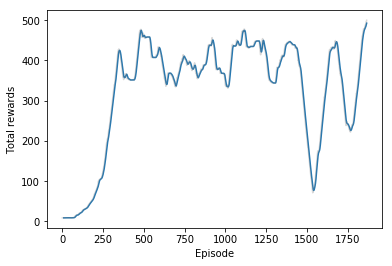

In [34]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

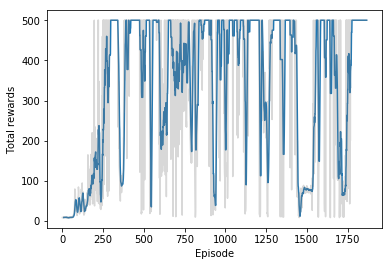

In [35]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Average losses')

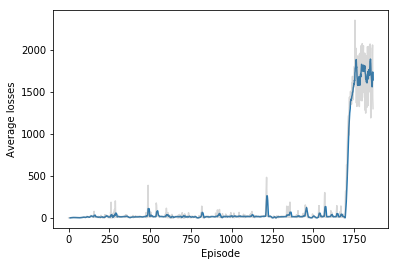

In [36]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [38]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episode/epoch
    for _ in range(10):
        total_reward = 0
        state = env.reset()
        initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]
        
        # Steps/batches
        while True:
            env.render()
            action_logits, initial_state = sess.run([model.actions_logits, model.final_state],
                                                    feed_dict = {model.states: state.reshape([1, -1]), 
                                                                 model.initial_state: initial_state})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # At the end of each episode
        print('total_reward:{}'.format(total_reward))

# Close the env
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.